In [2]:
from FlowCal import io
from FlowCal import gate
from FlowCal import plot
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from os import listdir
import seaborn as sns
from scipy.stats.mstats import gmean
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 10}     
sns.set(context='notebook',style="white",font='Helvetica',font_scale=1.5,rc=paper_rc)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## make dictionary based on plate maps

In [55]:
plates_dict = pd.read_csv('pkdp112_1235wt/mcherry_gfp_ctrl_ko_rescue.csv',sep=',',header=None)
plates_dict.columns = ['WELL','MUTATION','PLATE','SUBSTRATE']
path = 'pkdp112_1235wt/'
files = listdir(path)
files_dict = {}
####
for file in files:
    well = file.split('.')[0].split('_')[-3]+file.split('.')[0].split('_')[-1]
    files_dict[well]=path+file
plates_dict['FILE'] = plates_dict.apply(lambda row: files_dict[row.PLATE+row.WELL],axis=1)

## fns

In [5]:
def process_fcs(filename,lowcut=0,lowcut_BL1A=0,lowcut_YL2A=0,fraction=0.8,title='title'):
    ###gating twice, first on absolute FSC-A greater than, then gating on density plot of 65% density. 
    ###may also want to use a polygon cutoff for increased consistency instead of a density cutoff.
    s = io.FCSData(filename)
    s_g1 = gate.high_low(s, channels='FSC-A', low=lowcut)
    s_g1 = gate.high_low(s_g1, channels='BL1-A', low=lowcut_BL1A)
    s_g1 = gate.high_low(s_g1, channels='YL2-A', low=lowcut_YL2A)
    s_g2 = gate.density2d(s_g1,channels=['FSC-A', 'SSC-A'],gate_fraction=fraction)
    ###
    return(s_g2)

def plot_fcs(s_g2,title):
    ### quick plot check
    plt.figure(figsize=[3,3])
    plot.scatter2d(s_g2,channels=['FSC-A', 'SSC-A'],yscale='logicle',xscale='logicle') 
    plt.title(title)
    ###
    plt.figure(figsize=[3,3])
    plot.scatter2d(s_g2,channels=['BL1-A', 'YL2-A'],yscale='logicle',xscale='logicle') 
    plt.title(title)

def process_onetrack(fcs):
    tmp = pd.DataFrame(fcs[:,['BL1-A', 'YL2-A']])
    tmp.columns = ['BL1-A', 'YL2-A']
    tmp = tmp['YL2-A']/tmp['BL1-A']
    return(tmp)
   
def process_trackorder(mutants):
    order = mutants.copy()
    order = order.apply(lambda row: process_onetrack(row['FCS']),axis=1)
    order = order.stack().reset_index()
    order = order.groupby('MUTATION', as_index=True).mean()[0].sort_values().index.tolist()
    ## reorder mutants
    mutants_ordered = []
    for mutation in order:
        mutants_ordered.append(mutants.loc[mutation])
    mutants_ordered = pd.concat(mutants_ordered)
    ## return
    return(mutants_ordered)

def plot_allbox(dists,substrate,save=None):
    ### format
    newindex = []
    numlist = '121212121212121212121212121212'
    for item,num in zip(dists.index.tolist(),numlist):
        newindex.append(item+'_'+num)
    dists.index = newindex
    ###
    plt.figure(figsize=(20,20))
    bar = dists.stack().reset_index()
    sns.boxplot(x="level_0", y=0, data=bar,fliersize=0,whis=0.5)
    plt.ylim(0,3.0)
    plt.xticks(rotation=90)
    plt.title(substrate)
    plt.tight_layout()
    ###
    if save != None:
        plt.savefig(save)

def plot_allbar(dists,substrate,save=None):
    ### format
    newindex = []
    numlist = '121212121212121212121212121212'
    for item,num in zip(dists.index.tolist(),numlist):
        newindex.append(item+'_'+num)
    dists.index = newindex
    ###
    plt.figure(figsize=(10,15))
    bar = dists.stack().reset_index()
    sns.barplot(x="level_0", y=0, data=bar,ci=95)
    plt.ylim(0,2.0)
    plt.xticks(rotation=90)
    plt.title(substrate)
    plt.tight_layout()
    ###
    if save != None:
        plt.savefig(save)
    
def plot_allviolin(dists,substrate):
    ### format
    newindex = []
    numlist = '121212121212121212121212121212'
    for item,num in zip(dists.index.tolist(),numlist):
        newindex.append(item+'_'+num)
    dists.index = newindex
    ###
    plt.figure(figsize=(20,10))
    bar = dists.stack().reset_index()
    sns.violinplot(x="level_0", y=0, data=bar,fliersize=0)
    plt.ylim(0,3)
    plt.xticks(rotation=90)
    plt.title(substrate)
    
def plot_alltrack(dists,xlim=(0.2,2.0)):
    ### format
    newindex = []
    numlist = '121212121212121212121212121212'
    for item,num in zip(dists.index.tolist(),numlist):
        newindex.append(item+'_'+num)
    dists.index = newindex
    df = dists.stack().reset_index()
    df = df[['level_0',0]]
    df.columns = ['MUTATION','x']
    ###### plotting
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.9, light=.7)
    g = sns.FacetGrid(df, row="MUTATION", hue="MUTATION", height=0.5,aspect=40,palette=pal)
    g.set(xlim=xlim)
    # Draw the densities in a few steps
    g.map(sns.kdeplot, "x",bw=0.2,
          alpha=1.0, linewidth=1.5,shade=False)
    g.map(sns.kdeplot, "x",bw=0.2,
          alpha=0.8, linewidth=2.0,shade=True)
    g.map(plt.axhline, y=0, lw=2)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-0.2, 0, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "x")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-0.9)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    
def bootstrap(dists,samplings=1000,sample_size=50):
    from sklearn.utils import resample
    from collections import OrderedDict
    ###
    dists['category'] = dists.index
    categories = list(OrderedDict.fromkeys(dists['category']))
    means_dists = []
    ### 
    for bucket in categories:
        ### slice out and sample each replicate with equal numbers from each rep composing a bootstrap bucket
        tmp = dists[dists.category==bucket]
        tmp.drop('category',inplace=True,axis=1)
        s1 = tmp.iloc[0].dropna()
        ### append means here 
        means = []
        for i in range(samplings):
            boot1 = resample(s1, replace=True, n_samples=2*sample_size)
            means.append(np.mean(boot1))
        means_dists.append(means)
    #### see bootstrapping results
    plt.figure()
    for meandist in means_dists:
        sns.kdeplot(meandist)
    plt.xlim(0.2,2)
    #### return
    bootstrapped = pd.DataFrame(means_dists,index=categories)
    return(bootstrapped)

###
def plot_bootstrap_box(dists,substrate,save=None):
    ###
    plt.figure(figsize=(10,15))
    bar = dists.stack().reset_index()
    sns.boxplot(x="level_0", y=0, data=bar,fliersize=0,whis=0.5)
    plt.ylim(0,2.0)
    plt.xticks(rotation=90)
    plt.title(substrate)
    plt.tight_layout()
    ###
    if save != None:
        plt.savefig(save)


### preprocess

In [64]:
lowcut = 3.0*10**5
lowcut_BL1A = 2.0*10**2
lowcut_YL2A = 2.0*10**2
fraction = 0.7
### cutoff
plates_dict['FCS'] = plates_dict.apply(lambda row: 
                  process_fcs(row.FILE,
                              lowcut=lowcut,
                              lowcut_BL1A = lowcut_BL1A,
                              lowcut_YL2A=lowcut_YL2A,
                              fraction=fraction,
                              title=str(list(row)))
                  ,axis=1)

In [60]:
### define a FCS master function
def fcs_master_list_ratios(filenames,low_cut,low_cut_BL1A,low_cut_YL2A,title,labels):
    ####
    s = [ io.FCSData(filename) for filename in filenames]
    ###gating twice, first on absolute FSC-A greater than, then gating on density plot of 65% density. 
    ###may also want to use a polygon cutoff for increased consistency instead of a density cutoff.
    s_g1 = [ gate.high_low(data, channels='FSC-A', low=low_cut) for data in s]
    s_g1 = [ gate.high_low(data, channels='BL1-A', low=low_cut_BL1A) for data in s_g1]
    s_g1 = [ gate.high_low(data, channels='YL2-A', low=low_cut_YL2A) for data in s_g1]
    s_g2 = [ gate.density2d(data,channels=['FSC-A', 'SSC-A'],gate_fraction=0.65) for data in s_g1]
    s_g3 = s_g2.copy()
    ### plot facs plot
    colors = ['#A9A9A9','#00008B','#800000','#d94701','#DFC723']
    i=0
    plt.figure(figsize=(6,5))
    for data in s_g3:
        if i == 0:
            tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
            tmp.index = [labels[i]]*len(tmp)
            tmp.columns = ['BL1-A', 'YL2-A']
            tmp = tmp['YL2-A']/tmp['BL1-A']
            wt_mean = tmp.mean()
            tmp = tmp/wt_mean
            sns.kdeplot(tmp,label=labels[i],color=colors[i],cut=3,clip=(0,2.0),shade=False,alpha=1)
        else:
            tmp = pd.DataFrame(data[:,['BL1-A', 'YL2-A']])
            tmp.index = [labels[i]]*len(tmp)
            tmp.columns = ['BL1-A', 'YL2-A']
            tmp = tmp['YL2-A']/tmp['BL1-A']
            tmp = tmp/wt_mean
            sns.kdeplot(tmp,label=labels[i],color=colors[i],cut=3,clip=(0,2.0),shade=False,alpha=1)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.xlim(-0.2,2.0)
        plt.xticks([0,1,2])
        i+=1
    ## save
    plt.title(title)
    plt.tight_layout()
    plt.savefig('figures_kde/_'+title+'.controls.svg',dpi=100)
    plt.show()
    return(s_g3)

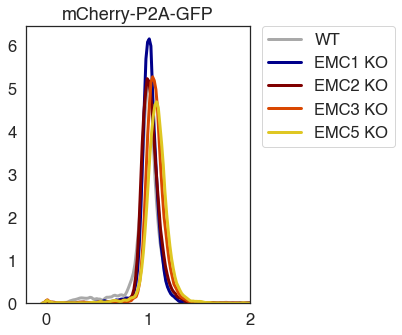

In [61]:
lowcut = 3.0*10**5
lowcut_BL1A = 2.0*10**2
lowcut_YL2A = 2.0*10**2
fraction = 0.7
############
for substrate in set(plates_dict.SUBSTRATE):
    tmp = plates_dict[plates_dict.SUBSTRATE==substrate]
    filenames = tmp.FILE.tolist()
    labels = tmp.MUTATION.tolist()
    title = substrate
    ###
    tmpfig = fcs_master_list_ratios(filenames,lowcut,lowcut_BL1A,lowcut_YL2A,title=title,labels=labels)


/Users/johnny/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


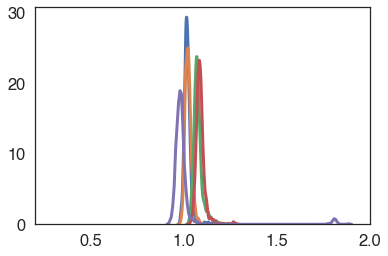

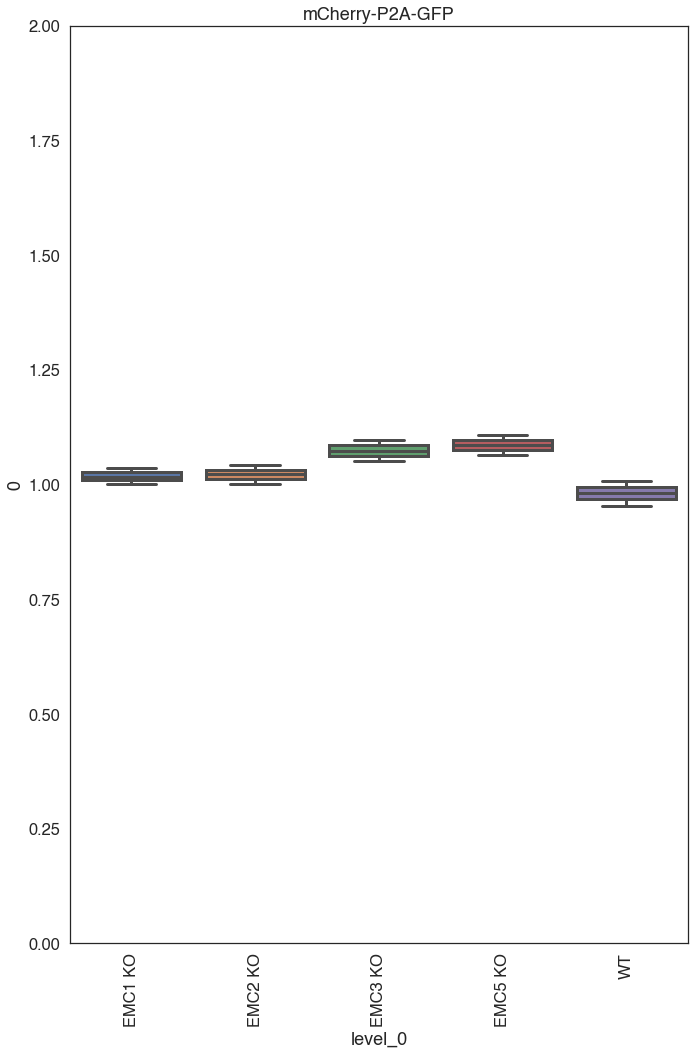

In [71]:
import scipy.stats as scistats
substrates = plates_dict['SUBSTRATE'].unique().tolist()
substrates.sort()
stats = []
###
for substrate in substrates:
    ### get a df for each substrate
    tmp = plates_dict[plates_dict.SUBSTRATE==substrate]
    ### fish out the WT and KO
    WT = tmp[tmp['MUTATION']=='WT']
    ### get just the mutants
    tmp = tmp[tmp['MUTATION']!='WT']
    ### formatting
    tmp.index = tmp.MUTATION
    WT.index = WT.MUTATION
    ### compile ratios
    tmp = tmp.apply(lambda row: process_onetrack(row['FCS']),axis=1)
    WT = WT.apply(lambda row: process_onetrack(row.FCS),axis=1)
    ### normalize all
    tmp = tmp/WT.stack().mean()
    WT = WT/WT.stack().mean()
    ### restack
    dists = pd.concat([tmp,WT])
    ### plotter
    means = bootstrap(dists)
    plot_bootstrap_box(means,substrate=substrate)
    ## plot_allbar(dists,substrate,save='figures/201017_EMC3_'+str(substrate)+'.pdf')
    ## plot_alltrack(dists)
    ##### do stats; one sided low
    pvals = []
    for item in means.index:
        ### create normal distributions from the data
        normal_wt = np.random.normal(np.mean(means.loc['WT']),np.std(means.loc['WT'],ddof=1),10000)
        wt_lo = np.percentile(a=normal_wt,q=1.0)
        wt_hi = np.percentile(a=normal_wt,q=99.0)
#         wt_lo = np.percentile(a=means.loc['WT'],q=1.0)
#         wt_hi = np.percentile(a=means.loc['WT'],q=99.0)
        ### note the standard deviation from wt was used as well
        normal_item = np.random.normal(np.mean(means.loc[item]),np.std(means.loc['WT'],ddof=1),10000)
        overlap = normal_item[normal_item < wt_hi]
        overlap = len(overlap)/len(normal_item)
#         overlap = means.loc[item][means.loc[item] > wt_lo]
#         overlap = len(overlap)/len(means.loc[item])
        pvals.append(overlap)
    ### stats
    pvals = pd.Series(pvals,index=means.index)
    pvals.name = str(substrate)
    stats.append(pvals)
### concat
stats = pd.concat(stats,axis=1,join='inner')
stats.to_csv('figures_kde/stats.mcherry.p2a.gfp.controls.hi.csv')

In [69]:
stats


,mCherry-P2A-GFP
EMC1 KO,0.9831
EMC2 KO,0.9835
EMC3 KO,0.9483
EMC5 KO,0.9274
WT,0.9919


In [ ]:
stats.to_csv('figures_kde/stats.controls.csv')

In [72]:
wt_hi

1.3036707023612362

In [ ]:
samplings=1000
sample_size=250
###
from sklearn.utils import resample
from collections import OrderedDict
###
dists['category'] = dists.index
categories = list(OrderedDict.fromkeys(dists['category']))
means_dists = []
### 
for bucket in categories:
    ### slice out and sample each replicate with equal numbers from each rep composing a bootstrap bucket
    tmp = dists[dists.category==bucket]
    tmp.drop('category',inplace=True,axis=1)
    s1 = tmp.iloc[0].dropna()
    ### append means here 
    means = []
    for i in range(samplings):
        boot1 = resample(s1, replace=False, n_samples=sample_size)

In [ ]:
boot1.mean()

In [ ]:
WT = WT.apply(lambda row: process_onetrack(row.FCS),axis=1)



## preprocess data using cutoffs

In [ ]:
lowcut = 3.0*10**5
lowcut_BL1A = 2.0*10**2
lowcut_YL2A = 2.0*10**2
fraction = 0.7
### cutoff
plates_dict['FCS'] = plates_dict.apply(lambda row: 
                  process_fcs(row.FILE,
                              lowcut=lowcut,
                              lowcut_BL1A = lowcut_BL1A,
                              lowcut_YL2A=lowcut_YL2A,
                              fraction=fraction,
                              title=str(list(row)))
                  ,axis=1)

## Group by substrate and do track plots

## biorep 1

In [ ]:
import scipy.stats as scistats
substrates = plates_dict['SUBSTRATE'].unique().tolist()
substrates.sort()
stats = []
###
for substrate in substrates:
    ### get a df for each substrate
    tmp = plates_dict[plates_dict.SUBSTRATE==substrate]
    tmp = tmp[tmp['MUTATION']!='delete']
    ### fish out the WT and KO
    WT = tmp[tmp['MUTATION']=='WT']
    WT = WT[WT['PURO']==True]
    WT = WT[WT['BIOREP1']==True]
    KO = tmp[tmp['MUTATION']=='KO']
    KO = KO[KO['PURO']==False]
    ### get just the mutants
    tmp = tmp[tmp['MUTATION']!='WT']
    tmp = tmp[tmp['MUTATION']!='KO']
    ### formatting
    tmp.index = tmp.MUTATION
    WT.index = WT.MUTATION
    KO.index = KO.MUTATION
    ### order
    tmp = process_trackorder(tmp)
    ### compile ratios
    tmp = tmp.apply(lambda row: process_onetrack(row['FCS']),axis=1)
    WT = WT.apply(lambda row: process_onetrack(row.FCS),axis=1)
    KO = KO.apply(lambda row: process_onetrack(row.FCS),axis=1)
    ### normalize all
    tmp = tmp/WT.stack().mean()
    KO = KO/WT.stack().mean()
    WT = WT/WT.stack().mean()
    ### restack
    dists = pd.concat([KO,tmp,WT])
    ### plotter
    means = bootstrap(dists)
    plot_bootstrap_box(means,substrate=substrate,save='figures/201017_EMC3_'+str(substrate)+'.pdf')
    ## plot_allbar(dists,substrate,save='figures/201017_EMC3_'+str(substrate)+'.pdf')
    ## plot_alltrack(dists)
    ##### do stats; one sided low
    pvals = []
    for item in means.index:
        wt_lo = np.percentile(a=means.loc['WT'],q=5.0)
        wt_hi = np.percentile(a=means.loc['WT'],q=95.0)
        ###
        overlap = means.loc[item][means.loc[item] > wt_lo]
        overlap = len(overlap)/len(means.loc[item])
        pvals.append(overlap)
    ### stats
    pvals = pd.Series(pvals,index=means.index)
    pvals.name = str(substrate)
    stats.append(pvals)
### concat
stats = pd.concat(stats,axis=1,join='inner')
stats.to_csv('figures/201017_EMC3.stats.lo.csv')

In [ ]:
import scipy.stats as scistats
substrates = plates_dict['SUBSTRATE'].unique().tolist()
substrates.sort()
stats = []
###
for substrate in substrates:
    ### get a df for each substrate
    tmp = plates_dict[plates_dict.SUBSTRATE==substrate]
    tmp = tmp[tmp['MUTATION']!='delete']
    ### fish out the WT and KO
    WT = tmp[tmp['MUTATION']=='WT']
    WT = WT[WT['PURO']==True]
    WT = WT[WT['BIOREP1']==True]
    KO = tmp[tmp['MUTATION']=='KO']
    KO = KO[KO['PURO']==False]
    ### get just the mutants
    tmp = tmp[tmp['MUTATION']!='WT']
    tmp = tmp[tmp['MUTATION']!='KO']
    ### formatting
    tmp.index = tmp.MUTATION
    WT.index = WT.MUTATION
    KO.index = KO.MUTATION
    ### order
    tmp = process_trackorder(tmp)
    ### compile ratios
    tmp = tmp.apply(lambda row: process_onetrack(row['FCS']),axis=1)
    WT = WT.apply(lambda row: process_onetrack(row.FCS),axis=1)
    KO = KO.apply(lambda row: process_onetrack(row.FCS),axis=1)
    ### normalize all
    tmp = tmp/WT.stack().mean()
    KO = KO/WT.stack().mean()
    WT = WT/WT.stack().mean()
    ### restack
    dists = pd.concat([KO,tmp,WT])
    ### plotter
    means = bootstrap(dists)
    plot_bootstrap_box(means,substrate=substrate,save='figures/201017_EMC3_'+str(substrate)+'.pdf')
    ## plot_allbar(dists,substrate,save='figures/201017_EMC3_'+str(substrate)+'.pdf')
    ## plot_alltrack(dists)
    ##### do stats; one sided low
    pvals = []
    for item in means.index:
        wt_lo = np.percentile(a=means.loc['WT'],q=5.0)
        wt_hi = np.percentile(a=means.loc['WT'],q=95.0)
        ###
        overlap = means.loc[item][means.loc[item] < wt_hi]
        overlap = len(overlap)/len(means.loc[item])
        pvals.append(overlap)
    ### stats
    pvals = pd.Series(pvals,index=means.index)
    pvals.name = str(substrate)
    stats.append(pvals)
### concat
stats = pd.concat(stats,axis=1,join='inner')
stats.to_csv('figures/201017_EMC3.stats.hi.csv')

## Biorep 2

In [ ]:
substrates = plates_dict['SUBSTRATE'].unique().tolist()
substrates.sort()
###
for substrate in substrates:
    ### get a df for each substrate
    tmp = plates_dict[plates_dict.SUBSTRATE==substrate]
    tmp = tmp[tmp['MUTATION']!='delete']
    ### fish out the WT and KO
    WT = tmp[tmp['MUTATION']=='WT']
    WT = WT[WT['PURO']==True]
    WT = WT[WT['BIOREP1']==False]
    KO = tmp[tmp['MUTATION']=='KO']
    KO = KO[KO['PURO']==False]
    ### get just the mutants
    tmp = tmp[tmp['MUTATION']!='WT']
    tmp = tmp[tmp['MUTATION']!='KO']
    ### formatting
    tmp.index = tmp.MUTATION
    WT.index = WT.MUTATION
    KO.index = KO.MUTATION
    ### order
    tmp = process_trackorder(tmp)
    ### compile ratios
    tmp = tmp.apply(lambda row: process_onetrack(row['FCS']),axis=1)
    WT = WT.apply(lambda row: process_onetrack(row.FCS),axis=1)
    KO = KO.apply(lambda row: process_onetrack(row.FCS),axis=1)
    ### normalize all
    tmp = tmp/WT.stack().mean()
    KO = KO/WT.stack().mean()
    WT = WT/WT.stack().mean()
    ### restack
    dists = pd.concat([KO,tmp,WT])
    ### plotter
    plot_allbox(dists,substrate)
    ## plot_alltrack(dists)

## Let's track plot it

In [ ]:
substrates = plates_dict['SUBSTRATE'].unique().tolist()
substrates.sort()
###
for substrate in substrates:
    ### get a df for each substrate
    tmp = plates_dict[plates_dict.SUBSTRATE==substrate]
    tmp = tmp[tmp['MUTATION']!='delete']
    ### fish out the WT and KO
    WT = tmp[tmp['MUTATION']=='WT']
    WT = WT[WT['PURO']==True]
    WT = WT[WT['BIOREP1']==False]
    KO = tmp[tmp['MUTATION']=='KO']
    KO = KO[KO['PURO']==False]
    ### get just the mutants
    tmp = tmp[tmp['MUTATION']!='WT']
    tmp = tmp[tmp['MUTATION']!='KO']
    ### formatting
    tmp.index = tmp.MUTATION
    WT.index = WT.MUTATION
    KO.index = KO.MUTATION
    ### order
    tmp = process_trackorder(tmp)
    ### compile ratios
    tmp = tmp.apply(lambda row: process_onetrack(row['FCS']),axis=1)
    WT = WT.apply(lambda row: process_onetrack(row.FCS),axis=1)
    KO = KO.apply(lambda row: process_onetrack(row.FCS),axis=1)
    ### normalize all
    tmp = tmp/WT.stack().mean()
    KO = KO/WT.stack().mean()
    WT = WT/WT.stack().mean()
    ### restack
    dists = pd.concat([KO,tmp,WT])
    ### plotter
#     plot_allbox(dists,substrate)
    plot_alltrack(dists)

In [ ]:
plot_alltrack(dists,xlim=(-0.2,3.5))

## Now i am showing the gating I used

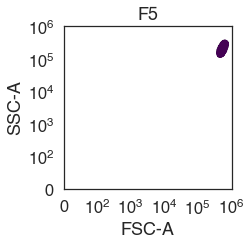

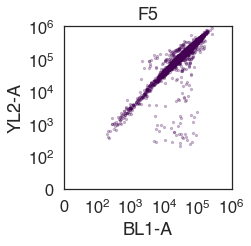

In [18]:
lowcut = 3.0*10**5
lowcut_BL1A = 2.0*10**2
lowcut_YL2A = 2.0*10**2
fraction = 0.7
WELL = 'F5'
### cutoff
data = process_fcs(plates_dict[plates_dict.WELL==WELL].FILE.tolist()[0],
            lowcut=lowcut,
            lowcut_BL1A = lowcut_BL1A,
            lowcut_YL2A=lowcut_YL2A,fraction=fraction,
            title=WELL)
### plot
plot_fcs(data,title=WELL)

## Here is with no gating

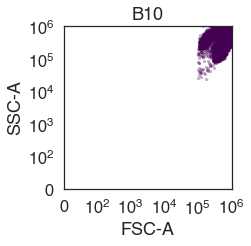

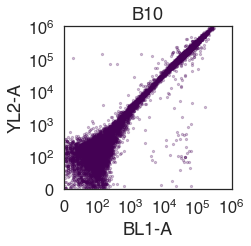

In [11]:
lowcut = 0
lowcut_BL1A = 0
lowcut_YL2A = 0
fraction = 1
WELL = 'B10'
### cutoff
data = process_fcs(plates_dict[plates_dict.WELL==WELL].FILE.tolist()[0],
            lowcut=lowcut,
            lowcut_BL1A = lowcut_BL1A,
            lowcut_YL2A=lowcut_YL2A,fraction=fraction,
            title=WELL)
### plot
plot_fcs(data,title=WELL)